# MNIST - EDA

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import keras

params = {'legend.fontsize': 'large',
          'figure.figsize': (10, 8),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

# Prevent Pandas from truncating displayed dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

sns.set(style="white")

SEED = 42

### Load & Preview Data

In [4]:
# Load master copies of data - these remain pristine
train_ = pd.read_csv("assets/train.csv")
test_ = pd.read_csv("assets/test.csv")
sample_submission = pd.read_csv("assets/sample_submission.csv")

# Take copies of the master dataframes
train = train_.copy()
test = test_.copy()

In [5]:
train.shape, test.shape

((42000, 785), (28000, 784))

Previewing the training data as a dataframe, we can see that there are 785 features: 784 pixel values and 1 label. The 784 pixel values correspond to 28x28 px images that have been "flattened" from 2D into 1D. The label is our target value, i.e. the correct digit value represented by the flattened vector.

In [6]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255,pixel256,pixel257,pixel258,pixel259,pixel260,pixel261,pixel262,pixel263,pixel264,pixel265,pixel266,pixel267,pixel268,pixel269,pixel270,pixel271,pixel272,pixel273,pixel274,pixel275,pixel276,pixel277,pixel278,pixel279,pixel280,pixel281,pixel282,pixel283,pixel284,pixel285,pixel286,pixel287,pixel288,pixel289,pixel290,pixel291,pixel292,pixel293,pixel294,pixel295,pixel296,pixel297,pixel298,pixel299,pixel300,pixel301,pixel302,pixel303,pixel304,pixel305,pixel306,pixel307,pixel308,pixel309,pixel310,pixel311,pixel312,pixel313,pixel314,pixel315,pixel316,pixel317,pixel318,pixel319,pixel320,pixel321,pixel322,pixel323,pixel324,pixel325,pixel326,pixel327,pixel328,pixel329,pixel330,pixel331,pixel332,pixel333,pixel334,pixel335,pixel336,pixel337,pixel338,pixel339,pixel340,pixel341,pixel342,pixel343,pixel344,pixel345,pixel346,pixel347,pixel348,pixel349,pixel350,pixel351,pixel352,pixel353,pixel354,pixel355,pixel356,pixel357,pixel358,pixel359,pixel360,pixel361,pixel362,pixel363,pixel364,pixel365,pixel366,pixel367,pixel368,pixel369,pixel370,pixel371,pixel372,pixel373,pixel374,pixel375,pixel376,pixel377,pixel378,pixel379,pixel380,pixel381,pixel382,pixel383,pixel384,pixel385,pixel386,pixel387,pixel388,pixel389,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399,pixel400,pixel401,pixel402,pixel403,pixel404,pixel405,pixel406,pixel407,pixel408,pixel409,pixel410,pixel411,pixel412,pixel413,pixel414,pixel415,pixel416,pixel417,pixel418,pixel419,pixel420,pixel421,pixel422,pixel423,pixel424,pixel425,pixel426,pixel427,pixel428,pixel429,pixel430,pixel431,pixel432,pixel433,pixel434,pixel435,pixel436,pixel437,pixel438,pixel439,pixel440,pixel441,pixel442,pixel443,pixel444,pixel445,pixel446,pixel447,pixel448,pixel449,pixel450,pixel451,pixel452,pixel453,pixel454,pixel455

In [7]:
# Separate the target variable from the digits
y = train.pop("label")

Obviously, viewing images as vectors of numbers is not very helpful. Instead, we can reverse engineer our recgonizable MNIST digits.

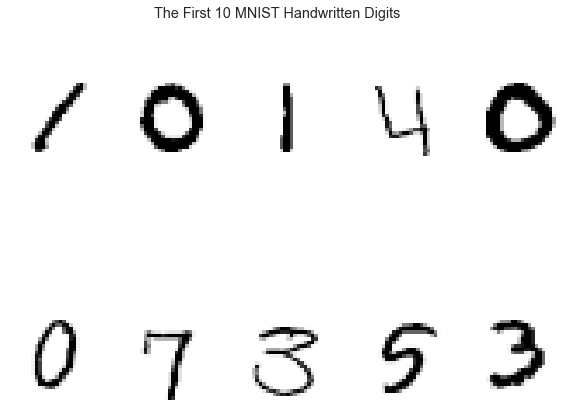

In [8]:
n_preview = 10
fig, ax = plt.subplots()

for i in range(n_preview):
    plt.subplot(2, 5, i+1)
    image = train.iloc[i].values.reshape((28,28))
    plt.imshow(image, cmap="Greys")
    plt.axis("off")

plt.suptitle("The First 10 MNIST Handwritten Digits", y=0.9)
plt.show()

Likewise, we can look at the corresponding true labels for the first 10 digits.

In [9]:
y[0:10].values

array([1, 0, 1, 4, 0, 0, 7, 3, 5, 3], dtype=int64)

### Explore the Target Distribution

The target variable is reasonably well-distributed between the 10 digits. This is good news - we won't have to deal with an imbalanced dataset.

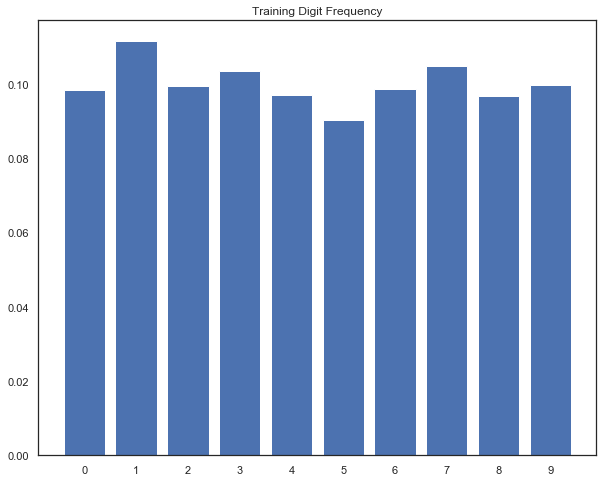

In [10]:
digit_frequency = y.value_counts(normalize=True).to_frame()
unique_digits= np.sort(y.unique())
unique_digits_str = [str(d) for d in unique_digits]

plt.bar(digit_frequency.index, digit_frequency["label"].values)
plt.title("Training Digit Frequency")
plt.xticks(unique_digits, unique_digits_str)
plt.show()

### Preprocessing

We need to scale pixel values to range from 0 to 1. This prevents some data points from having a disproportionate impact on our model.

In [11]:
train = train / np.max(np.max(train))
test = test / np.max(np.max(test))

### Baseline Logistic Regression Model

Let's compare two methods of establishing a baseline model: `train_test_split` and `cross_validate`.

First, we'll split the data into training and validation sets. Then a Logistic Regression model is fit on the training set and scored on the validation set.

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(train, y, test_size=0.2, random_state=SEED)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((33600, 784), (8400, 784), (33600,), (8400,))

In [44]:
lr = LogisticRegression(max_iter=1000)

lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
yhat = lr.predict(X_valid)
score = lr.score(X_valid, y_valid)
print("Baseline score: {:.1%}".format(score))

Baseline score: 91.9%


So our basic Logistic Regression model scores in the low 90s! Where is it going wrong?

When we create a confusion matrix of actual vs. predicted labels, we see that the model's errors are reasonable. For example, `3` is often mis-classified as `8`. Likewise, there is some confusion between `7` and `9`.

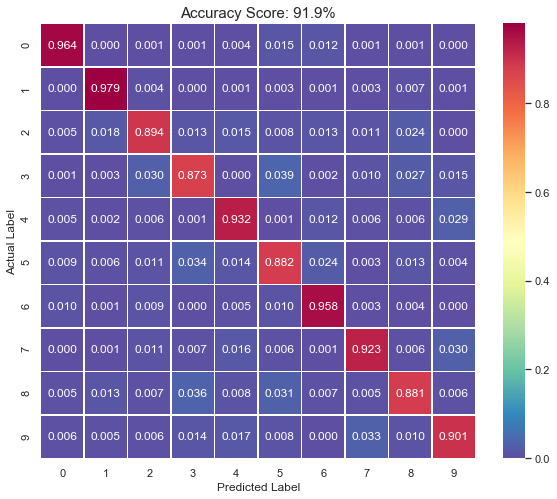

In [38]:
c_matrix = confusion_matrix(y_valid, yhat, normalize="true")

plt.figure()
sns.heatmap(c_matrix, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = "Spectral_r")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.title("Accuracy Score: {:.1%}".format(score), size = 15)
plt.show()

**But**, before we get too comfortable with our 91.9% accuracy, let's check to see how the target distributions vary between the training and validation sets.

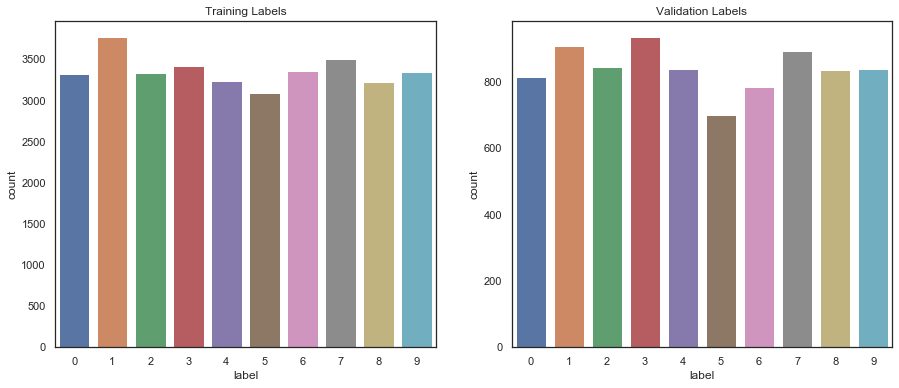

In [55]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

sns.countplot(y_train, ax=ax[0])
sns.countplot(y_valid, ax=ax[1])
ax[0].set_title("Training Labels")
ax[1].set_title("Validation Labels")
plt.show()

In [61]:
y_train.value_counts(normalize=True).sort_values(ascending=False)

1    0.112351
7    0.104405
3    0.101607
6    0.099762
9    0.099702
2    0.099137
0    0.098690
4    0.096220
8    0.096071
5    0.092054
Name: label, dtype: float64

In [62]:
y_valid.value_counts(normalize=True).sort_values(ascending=False)

3    0.111548
1    0.108214
7    0.106310
2    0.100714
4    0.099881
9    0.099762
8    0.099405
0    0.097143
6    0.093452
5    0.083571
Name: label, dtype: float64

The validation set appears to have disproportionately fewer `5`s. Interesting.

Let's see if performing cross validation gives us better results on the validation set.

In [35]:
lr = LogisticRegression(max_iter=1000)

cv_results = cross_validate(lr, train, y, cv=5, return_train_score=True)
cv_results.keys()

dict_keys(['fit_time', 'score_time', 'test_score', 'train_score'])

In [63]:
print("Train: {}, Validation: {}".format(cv_results["train_score"].mean(), cv_results["test_score"].mean()))

Train: 0.9458630952380952, Validation: 0.9182142857142856


Appears that the model does indeed score in the low 90s, regardless of the particular split that we use for the data.

### Previewing Misclassified Digits

In [105]:
misclassified = []
for i, (pred, actual) in enumerate(zip(yhat, y_valid)):
    if pred != actual:
        misclassified.append(i)

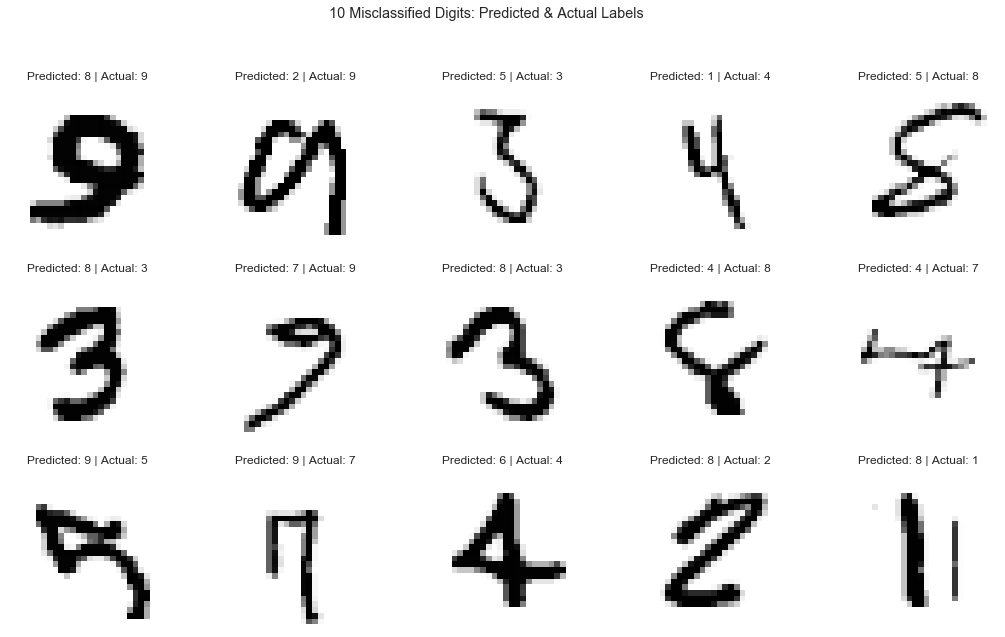

In [131]:
n_preview = 15
samples = X_valid.iloc[misclassified]
fig, ax = plt.subplots(figsize=(18,10))

for i in range(n_preview):
    plt.subplot(3, 5, i+1)
    image = samples.iloc[i].values.reshape((28,28))
    plt.imshow(image, cmap="Greys")
    plt.title("Predicted: {} | Actual: {}".format(yhat[misclassified[i]], y_valid.values[misclassified[i]]))
    plt.axis("off")

plt.suptitle("10 Misclassified Digits: Predicted & Actual Labels", y=0.99)
plt.show()